# Functions for evaluating signal-to-noise ratio (SNR)

Isaac Cheng - 2022

Tries to reproduce Table 3-6 of the CASTOR Science Maturation Study.

Resources:
- [CCD Signal/Noise](http://slittlefair.staff.shef.ac.uk/teaching/phy217/lectures/instruments/L14/index.html)


In [1]:
# I only need the following line since I'm using remote VS Code
%cd "/arc/home/IsaacCheng/CASTOR/ETC/notebooks"

import numpy as np
import pandas as pd
import astropy.units as u
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import interp1d
from IPython.core.display import display

# Import my own modules
import sys

sys.path.append("../")
import castor_etc.constants as const
import castor_etc.parameters as params
import castor_etc.filepaths as fp
from castor_etc.conversions import mag_to_flux, fnu_to_flam, fnu_to_photlam, flam_to_photlam
from castor_etc.energy import calc_photon_energy
from castor_etc.load_files import load_sky_background, load_passbands
from castor_etc.data.background.background_values import GEOCORONAL_FLUX_AVG, GEOCORONAL_WAVELENGTH, GEOCORONAL_LINEWIDTH
from castor_etc.snr import _calc_t_from_snr

/arc/home/IsaacCheng/CASTOR/ETC/notebooks


## Trying to replicate Table 3-6 from the CASTOR SMS...


In [2]:
#
# Set parameters
#
PASSBANDS = params.PASSBANDS
NPIX = (
    np.pi * (1.4 * params.FWHM / 2) ** 2 / (params.PX_SCALE) ** 2
).value  # number of pixels of the source
# NPIX = (
#     np.pi * (1.4 * const.FWHM / 2) ** 2 / (1378.8 / 2 / 5760) ** 2
# ).value  # number of pixels of the source
INTERP_KIND = "linear"  # type of interpolation to use for sky background
print(NPIX)

passband_centers = {key: np.mean(lims) for key, lims in params.PASSBAND_LIMITS.items()}
PHOT_ZPTS = pd.DataFrame({"uv": 24.23, "u": 24.71, "g": 24.78}, index=[0])  # AB mag for 1 electron/s
SKY_BACKGROUND_MAG_DENSITY = {"uv": 26.08, "u": 23.74, "g": 22.60}  # AB mag/arcsec^2
# print(passband_centers)

MAG_TO_FLUX_BASE = 100 ** 0.2  # approx. 2.512


3.463605900582746


In [4]:
#
# Passband response curves
#
castor_passbands = load_passbands(filters=PASSBANDS, limits=None, resolution=None)
passband_sum = dict.fromkeys(PASSBANDS)
for band, response in castor_passbands.items():
    print(f"{band}-band Response:")
    display(response)
    passband_sum[band] = np.sum(response["wavelength"].values)
#
# Sky background
#
sky_background_mag = pd.DataFrame(SKY_BACKGROUND_MAG_DENSITY, index=[0])  # AB mag/arcsec^2
print("sky_background_mag")
display(sky_background_mag)
# Convert mag to flux
sky_background_fnu = mag_to_flux(sky_background_mag, zpt=-48.60)[0]  # erg/s/cm^2/Hz / arcsec^2
phot_zpt_fnu = mag_to_flux(PHOT_ZPTS, zpt=-48.60)[0]  # erg/s/cm^2/Hz
sky_background_e_rate2 = sky_background_fnu / phot_zpt_fnu * params.PX_AREA.value
# Convert mag to electron/s directly
sky_background_e_rate = (
    MAG_TO_FLUX_BASE ** (PHOT_ZPTS - sky_background_mag) * params.PX_AREA.value * NPIX
)
print("sky background e rate2")
display(sky_background_e_rate2)  # electron/s
print("sky background e rate")
display(sky_background_e_rate)  # electron/s
#
# Geocoronal emission (assume geocoronal emission constant over entire aperture)
#
geo_background = (
    GEOCORONAL_FLUX_AVG
    * params.PX_AREA.value
    * params.MIRROR_AREA.value
    / calc_photon_energy(
        wavelength=GEOCORONAL_WAVELENGTH.value, wavelength_err=0.0
    )[0]
)  # photon/s/A
for band in PASSBANDS:
    throughput = castor_passbands[band]["throughput"].values
    #
    # Calculate total background noise from sky and geocoronal emission. Assume background
    # is constant over wavelength resolution (e.g., 10 angstroms) and is uniform over the
    # whole aperture.
    #
    band_start = (castor_passbands[band]["wavelength"].iloc[0] * u.um).to(u.AA).value
    band_end = (castor_passbands[band]["wavelength"].iloc[-1] * u.um).to(u.AA).value
    # Add geocoronal emission line [O II] 2471A to the relevant passband
    if (GEOCORONAL_WAVELENGTH.value >= band_start) & (
        GEOCORONAL_WAVELENGTH.value <= band_end
    ):
        throughput_interp = interp1d(
            castor_passbands[band]["wavelength"].values,
            throughput,
            kind=INTERP_KIND,
            bounds_error=False,
            fill_value=np.nan,
        )
        geo_throughput = throughput_interp((GEOCORONAL_WAVELENGTH).to(u.um).value)
        sky_background_e_rate[band] += (
            geo_background * geo_throughput * NPIX * GEOCORONAL_LINEWIDTH.value
        )
print("sky background e rate with geocoronal emission")
display(sky_background_e_rate)  # electron/s
#
# Dark current
#
# dark_current = const.DARK_CURRENT * NPIX  # electron/s
dark_current = 0  # electron/s
#
# Read noise
#
read_noise_sq = params.READ_NOISE ** 2 * NPIX  # electrons^2
# read_noise_sq = 2.9 ** 2 * NPIX  # electrons^2


uv-band Response:


,wavelength,throughput
0,0.150,0.014345
1,0.151,0.015924
2,0.152,0.017648
3,0.153,0.019521
4,0.154,0.021553
...,...,...
146,0.296,0.017400
147,0.297,0.013037
148,0.298,0.009245
149,0.299,0.006053


u-band Response:


,wavelength,throughput
0,0.300,0.524463
1,0.301,0.527992
2,0.302,0.531407
3,0.303,0.534705
4,0.304,0.537884
...,...,...
96,0.396,0.328489
97,0.397,0.313956
98,0.398,0.299435
99,0.399,0.284926


g-band Response:


,wavelength,throughput
0,0.400,0.343162
1,0.401,0.360624
2,0.402,0.376599
3,0.403,0.391541
4,0.404,0.405954
...,...,...
146,0.546,0.554785
147,0.547,0.540715
148,0.548,0.526205
149,0.549,0.511509


sky_background_mag


,uv,u,g
0,26.08,23.74,22.6


sky background e rate2


,uv,u,g
0,0.00182,0.024434,0.074473


sky background e rate


,uv,u,g
0,0.006303,0.084631,0.257946


sky background e rate with geocoronal emission


,uv,u,g
0,0.006657,0.084631,0.257946


In [5]:
ab_mags = np.arange(22.0, 29.0, 0.5)  # relative AB magnitudes
ab_source_e_rate = pd.DataFrame(index=ab_mags, columns=PASSBANDS)  # electron/s
for band in PASSBANDS:
    for ab_mag in ab_mags:
        ab_source_e_rate[band][ab_mag] = MAG_TO_FLUX_BASE ** (
            PHOT_ZPTS[band].values[0] - ab_mag
        )
display(ab_source_e_rate)


,uv,u,g
22.0,7.798301,12.133889,12.941958
22.5,4.920395,7.655966,8.165824
23.0,3.10456,4.830588,5.152286
23.5,1.958845,3.047895,3.250873
24.0,1.235947,1.923092,2.051162
24.5,0.77983,1.213389,1.294196
25.0,0.49204,0.765597,0.816582
25.5,0.310456,0.483059,0.515229
26.0,0.195884,0.304789,0.325087
26.5,0.123595,0.192309,0.205116


In [5]:
#
TARGET_SNRS = [5, 10]
#
t_lim = {
    snr: pd.DataFrame(index=ab_mags, columns=PASSBANDS) for snr in TARGET_SNRS
} # time to reach magnitude given target SNR (s)
# 
for target_snr in TARGET_SNRS:
    for band in PASSBANDS:
        tmp_sky_background_e_rate = sky_background_e_rate[band].values[0]
        for ab_mag in ab_mags:
            tmp_ab_source_e_rate = ab_source_e_rate[band][ab_mag]
            t = 0  # second
            snr = 0  # signal to noise ratio
            while snr < target_snr:
                t += 1
                signal = tmp_ab_source_e_rate * t  # electrons
                noise = np.sqrt(
                    signal
                    + tmp_sky_background_e_rate * t
                    + dark_current * t
                    + read_noise_sq
                )
                snr = signal / noise
                if t >= 60000:
                    print(f"Exiting {band} band at AB magnitude of {ab_mag}")
                    break
            t_lim[target_snr][band][ab_mag] = t

In [6]:
#
TARGET_SNRS = [5, 10]
#
t_lim2 = {
    snr: pd.DataFrame(index=ab_mags, columns=PASSBANDS) for snr in TARGET_SNRS
}  # time to reach magnitude given target SNR (s)
#
for target_snr in TARGET_SNRS:
    for band in PASSBANDS:
        tmp_sky_background_e_rate = sky_background_e_rate[band].values[0]
        for ab_mag in ab_mags:
            tmp_ab_source_e_rate = ab_source_e_rate[band][ab_mag]
            t = _calc_t_from_snr(
                snr=target_snr,
                signal=tmp_ab_source_e_rate,
                npix=NPIX,
                totskynoise=tmp_sky_background_e_rate / NPIX,
                darkcurrent=dark_current / NPIX,
            )
            t_lim2[target_snr][band][ab_mag] = t


In [8]:
for (snr, df), (_, df2) in zip(t_lim.items(), t_lim2.items()):
    print(f"TARGET SNR = {snr}")
    display(df)
    display(df2)
    print(df == np.ceil(df2))

TARGET SNR = 5


,uv,u,g
22.0,5,3,3
22.5,8,5,5
23.0,12,8,7
23.5,18,12,12
24.0,29,19,19
24.5,45,30,31
25.0,72,49,51
25.5,114,80,88
26.0,182,133,159
26.5,292,229,303


,uv,u,g
22.0,4.4799,2.88901,2.72818
22.5,7.10214,4.58917,4.35184
23.0,11.2611,7.29949,6.96771
23.5,17.8601,11.6347,11.2212
24.0,28.3377,18.6057,18.2355
24.5,44.991,29.9066,30.0489
25.0,71.504,48.4583,50.5599
25.5,113.825,79.493,87.6931
26.0,181.655,132.862,158.588
26.5,291.068,228.242,302.381


        uv     u     g
22.0  True  True  True
22.5  True  True  True
23.0  True  True  True
23.5  True  True  True
24.0  True  True  True
24.5  True  True  True
25.0  True  True  True
25.5  True  True  True
26.0  True  True  True
26.5  True  True  True
27.0  True  True  True
27.5  True  True  True
28.0  True  True  True
28.5  True  True  True
TARGET SNR = 10


,uv,u,g
22.0,15,10,9
22.5,23,15,15
23.0,37,24,23
23.5,58,38,37
24.0,92,61,61
24.5,146,98,101
25.0,231,160,174
25.5,369,266,309
26.0,590,453,575
26.5,949,796,1130


,uv,u,g
22.0,14.4147,9.30964,8.81876
22.5,22.8549,14.8029,14.1059
23.0,36.2456,23.5818,22.6815
23.5,57.5031,37.6787,36.7673
24.0,91.2812,60.4819,60.3411
24.5,145.035,97.7851,100.869
25.0,230.782,159.843,173.145
25.5,368.067,265.634,308.192
26.0,589.14,452.179,574.506
26.5,948.312,795.902,1129.77


        uv     u     g
22.0  True  True  True
22.5  True  True  True
23.0  True  True  True
23.5  True  True  True
24.0  True  True  True
24.5  True  True  True
25.0  True  True  True
25.5  True  True  True
26.0  True  True  True
26.5  True  True  True
27.0  True  True  True
27.5  True  True  True
28.0  True  True  True
28.5  True  True  True


In [7]:
for snr, df in t_lim.items():
    print(f"TARGET SNR = {snr}")
    display(df)
    print(df.to_latex())

TARGET SNR = 5


,uv,u,g
22.0,5,3,3
22.5,8,5,5
23.0,12,8,7
23.5,18,12,12
24.0,29,19,19
24.5,45,30,31
25.0,72,49,51
25.5,114,80,88
26.0,182,133,159
26.5,292,229,303


\begin{tabular}{llll}
\toprule
{} &    uv &     u &     g \\
\midrule
22.0 &     5 &     3 &     3 \\
22.5 &     8 &     5 &     5 \\
23.0 &    12 &     8 &     7 \\
23.5 &    18 &    12 &    12 \\
24.0 &    29 &    19 &    19 \\
24.5 &    45 &    30 &    31 \\
25.0 &    72 &    49 &    51 \\
25.5 &   114 &    80 &    88 \\
26.0 &   182 &   133 &   159 \\
26.5 &   292 &   229 &   303 \\
27.0 &   470 &   408 &   612 \\
27.5 &   765 &   765 &  1313 \\
28.0 &  1263 &  1522 &  2959 \\
28.5 &  2134 &  3214 &  6919 \\
\bottomrule
\end{tabular}

TARGET SNR = 10


,uv,u,g
22.0,15,10,9
22.5,23,15,15
23.0,37,24,23
23.5,58,38,37
24.0,92,61,61
24.5,146,98,101
25.0,231,160,174
25.5,369,266,309
26.0,590,453,575
26.5,949,796,1130


\begin{tabular}{llll}
\toprule
{} &    uv &      u &      g \\
\midrule
22.0 &    15 &     10 &      9 \\
22.5 &    23 &     15 &     15 \\
23.0 &    37 &     24 &     23 \\
23.5 &    58 &     38 &     37 \\
24.0 &    92 &     61 &     61 \\
24.5 &   146 &     98 &    101 \\
25.0 &   231 &    160 &    174 \\
25.5 &   369 &    266 &    309 \\
26.0 &   590 &    453 &    575 \\
26.5 &   949 &    796 &   1130 \\
27.0 &  1540 &   1464 &   2348 \\
27.5 &  2534 &   2834 &   5134 \\
28.0 &  4250 &   5800 &  11703 \\
28.5 &  7333 &  12511 &  27532 \\
\bottomrule
\end{tabular}



In [25]:
snr_vals = pd.DataFrame(index=ab_mags, columns=PASSBANDS)
TARGET_TIME = 3  # seconds
for band in PASSBANDS:
    tmp_sky_background_e_rate = sky_background_e_rate[band].values[0]
    for ab_mag in ab_mags:
        tmp_ab_source_e_rate = ab_source_e_rate[band][ab_mag]
        signal = tmp_ab_source_e_rate * TARGET_TIME  # electrons
        noise = np.sqrt(
            signal
            + tmp_sky_background_e_rate * TARGET_TIME
            + dark_current * TARGET_TIME
            + read_noise_sq
        )
        snr_vals[band][ab_mag] = signal / noise

In [26]:
snr_vals

,uv,u,g
22.0,3.82685,5.11666,5.30529
22.5,2.75348,3.76674,3.91124
23.0,1.92983,2.70489,2.81317
23.5,1.31883,1.89201,1.97094
24.0,0.881667,1.29065,1.34647
24.5,0.579149,0.861535,0.899897
25.0,0.375487,0.565276,0.590997
25.5,0.241206,0.36619,0.383109
26.0,0.153976,0.235099,0.246076
26.5,0.0978834,0.15002,0.157073


In [9]:
# 
# Load Table 3-6
# 
tab36 = pd.read_csv(
    fp.DATAPATH + "SMS_table_3-6.txt",
    sep=" ",
    header=0,
    comment="#",
)
tab36

,mag,uv_10,u_10,g_10,uv_5,u_5,g_5
0,22.0,31,20,19,9,6,6
1,22.5,49,32,30,14,9,8
2,23.0,78,51,48,22,14,14
3,23.5,123,81,78,34,22,22
4,24.0,197,129,128,56,36,36
5,24.5,309,208,217,87,59,59
6,25.0,498,339,372,141,95,100
7,25.5,783,569,655,219,155,171
8,26.0,1267,964,1206,356,266,323
9,26.5,2039,1698,2389,561,455,609


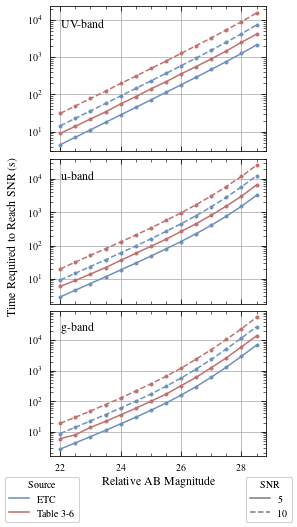

In [17]:
# 
# Plot
#
t_factor = 1  # multiply all times by this factor
# t_lim = t_lim2
for snr in t_lim:
    t_lim[snr] *= t_factor
plot_params = {
    # Line styles for each SNR
    "ls_5": "-",
    "ls_10": "--",
    # Colours for each band
    "etc": sns.color_palette("vlag")[0],
    "tab36": sns.color_palette("vlag")[-1],
}
import matplotlib as mpl
fig, axs = plt.subplots(nrows=3, sharex=True, figsize=mpl.figure.figaspect(2))
for band, ax in zip(PASSBANDS, axs):
    for snr in TARGET_SNRS:
        ls = plot_params[f"ls_{snr}"]
        ax.plot(ab_mags, t_lim[snr][band], ls=ls, color=plot_params["etc"], marker=".")
        ax.plot(tab36["mag"], tab36[f"{band}_{snr}"], ls=ls, color=plot_params["tab36"], marker=".")
    if band == "uv":
        band = band.upper()
    ax.text(0.05, 0.86, band + "-band", c="k", ha="left", transform=ax.transAxes, fontsize=12)
    ax.semilogy()
fig.subplots_adjust(top=0.9, left=0.15, right=0.9, bottom=0.12, hspace=0.05)
handles1 = [ax.plot([],[], color="grey", ls=plot_params[f"ls_{snr}"])[0] for snr in TARGET_SNRS]
leg1 = fig.legend(handles=handles1, labels=TARGET_SNRS, loc="lower right", title="SNR")
fig.add_artist(leg1)
handles2 = [ax.plot([],[], color=plot_params[f"{source}"])[0] for source in ["etc", "tab36"]]
leg2 = fig.legend(handles=handles2, labels=["ETC", "Table~3-6"], loc="lower left", title="Source")
fig.add_artist(leg2)
# fig.text(0.5, 0.05, "Relative AB Magnitude", ha="center", fontsize=12)
ax.set_xlabel("Relative AB Magnitude", fontsize=12)
fig.text(
    0.0,
    0.5,
    "Time Required to Reach SNR (s)",
    va="center",
    rotation="vertical",
    fontsize=12,
)
# fig.savefig(const.OUTPATH + f"all_snr_times_npix{NPIX:.2f}.pdf")
fig.savefig(f"all_snr_times_npix{NPIX:.2f}_readnoise{params.READ_NOISE}_darkcurrent{dark_current}.pdf")
plt.show()

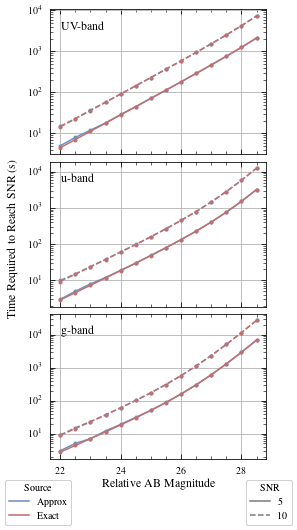

In [10]:
# 
# Plot
#
plot_params = {
    # Line styles for each SNR
    "ls_5": "-",
    "ls_10": "--",
    # Colours for each band
    "etc": sns.color_palette("vlag")[0],
    "etc2": sns.color_palette("vlag")[-1],
}
import matplotlib as mpl
fig, axs = plt.subplots(nrows=3, sharex=True, figsize=mpl.figure.figaspect(2))
for band, ax in zip(PASSBANDS, axs):
    for snr in TARGET_SNRS:
        ls = plot_params[f"ls_{snr}"]
        ax.plot(ab_mags, t_lim[snr][band], ls=ls, color=plot_params["etc"], marker=".")
        ax.plot(ab_mags, t_lim2[snr][band], ls=ls, color=plot_params["etc2"], marker=".")
    if band == "uv":
        band = band.upper()
    ax.text(0.05, 0.86, band + "-band", c="k", ha="left", transform=ax.transAxes, fontsize=12)
    ax.semilogy()
fig.subplots_adjust(top=0.9, left=0.15, right=0.9, bottom=0.12, hspace=0.05)
handles1 = [ax.plot([],[], color="grey", ls=plot_params[f"ls_{snr}"])[0] for snr in TARGET_SNRS]
leg1 = fig.legend(handles=handles1, labels=TARGET_SNRS, loc="lower right", title="SNR")
fig.add_artist(leg1)
handles2 = [ax.plot([],[], color=plot_params[f"{source}"])[0] for source in ["etc", "etc2"]]
leg2 = fig.legend(handles=handles2, labels=["Approx", "Exact"], loc="lower left", title="Source")
fig.add_artist(leg2)
# fig.text(0.5, 0.05, "Relative AB Magnitude", ha="center", fontsize=12)
ax.set_xlabel("Relative AB Magnitude", fontsize=12)
fig.text(
    0.0,
    0.5,
    "Time Required to Reach SNR (s)",
    va="center",
    rotation="vertical",
    fontsize=12,
)
# fig.savefig(const.OUTPATH + f"all_snr_times_npix{NPIX:.2f}.pdf")
fig.savefig(f"approx_vs_exact_times.pdf")
plt.show()

## Comparing sky backgrounds...


   wavelength    earthshine  zodiacal_light  total_sky_background
0        2000  6.080923e-09    6.278612e-07          6.341873e-07
1        2500  1.512323e-08    3.785750e-06          3.795634e-06
2        3000  1.696174e-06    1.933401e-05          2.099460e-05
3        3500  1.152726e-05    3.764004e-05          4.912579e-05
4        4000  2.625314e-05    4.934325e-05          7.559639e-05
5        4500  4.608137e-05    8.842642e-05          1.346857e-04
6        5000  5.199228e-05    1.002285e-04          1.522208e-04


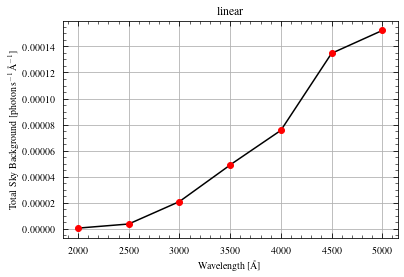

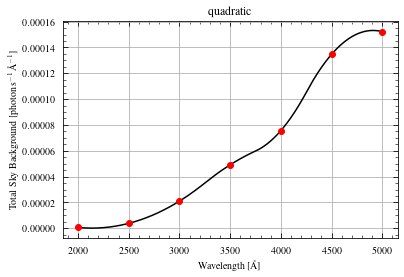

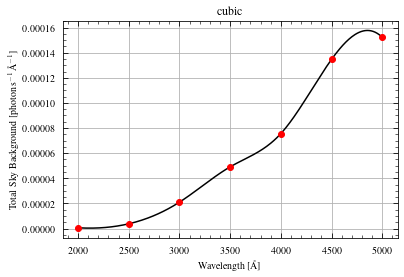

In [2]:
RESOLUTION = 1 * u.nm  # common resolution for interpolation
PASSBAND_TOT_LIMITS = [
    min(const.PASSBAND_LIMITS.values(), key=lambda x: x[0])[0] * u.um,
    max(const.PASSBAND_LIMITS.values(), key=lambda x: x[1])[1] * u.um,
]  # minimum and maximum wavelength covered by the telescope


sky_background_raw = load_sky_background(limits=PASSBAND_TOT_LIMITS)
for col in sky_background_raw.columns:
    if col == "wavelength":
        continue
    sky_background_raw[col] = (
        sky_background_raw[col]
        * const.PX_AREA
        * const.APER_AREA
        / calc_photon_energy(
            wavelength=sky_background_raw["wavelength"] * u.AA, wavelength_err=0.0
        )[0]
    )  # photon/s/A
print(sky_background_raw)

interp_kinds = ["linear", "quadratic", "cubic"]
tmp_wavelengths = np.arange(
    PASSBAND_TOT_LIMITS[0],
    PASSBAND_TOT_LIMITS[1] + 0.5 * RESOLUTION.to(u.AA).value,
    RESOLUTION.to(u.AA).value,
)
for kind in interp_kinds:
    tmp_interp = interp1d(
        sky_background_raw["wavelength"].values,
        sky_background_raw["total_sky_background"].values,
        kind=kind,
        bounds_error=False,
        fill_value=np.nan,
    )
    fig, ax = plt.subplots()
    ax.plot(tmp_wavelengths, tmp_interp(tmp_wavelengths), "k-")
    ax.plot(
        sky_background_raw["wavelength"], sky_background_raw["total_sky_background"], "ro"
    )
    ax.set_xlabel(r"Wavelength [\AA]")
    ax.set_ylabel(r"Total Sky Background [$\rm photon\,s^{-1}\,$\AA$^{-1}$]")
    ax.set_title(kind)
    plt.show()


In [2]:
UV_WAVELENGTHS = {"fuv": 1530 * u.AA, "nuv": 2310 * u.AA} # from Murthy+2010
UV_PASSBAND_LIMITS = {"fuv": [1350, 1750] * u.AA, "nuv": [1750, 2850] * u.AA}
murthy_raw = pd.read_csv(
    const.DATAPATH + "background/Murthy+2010_GALEX_NUV+FUV_background.txt",
    sep=" +",
    header=None,
    skiprows=17,
    comment="#",
    engine="python",
    names=["glon", "glat", "tfuv", "tnuv", "fuv", "nuv"],
)  # sep=" +" is Python regex to match a variable number of spaces
murthy_raw  # photon/cm^2/s/sr/A


,glon,glat,tfuv,tnuv,fuv,nuv
0,261.46,-40.15,582.28,1117.63,393.93,559.12
1,240.38,-49.19,457.28,1001.70,335.00,427.72
2,239.27,-47.61,454.90,979.00,331.01,404.52
3,239.09,-48.54,445.51,918.88,226.52,284.49
4,238.91,-49.47,513.77,1052.24,395.05,474.03
...,...,...,...,...,...,...
31897,155.03,-0.59,2096.56,2471.87,2057.08,1739.85
31898,149.14,3.02,1685.15,1928.11,1622.84,1230.23
31899,157.49,-0.16,2555.30,2503.70,2527.97,1751.10
31900,297.28,-15.54,2509.43,2575.54,2303.80,1981.85


In [12]:
murthy = (
    murthy_raw.iloc[:, 2:]
    * (const.PX_AREA * u.arcsec ** 2).to(u.sr).value
    * const.APER_AREA
)
murthy.insert(loc=0, column="glon", value=murthy_raw["glon"])
murthy.insert(loc=1, column="glat", value=murthy_raw["glat"])
with pd.option_context("display.float_format", "{:e}".format):
    display(murthy)


,glon,glat,tfuv,tnuv,fuv,nuv
0,2.614600e+02,-4.015000e+01,1.074908e-06,2.063183e-06,7.272080e-07,1.032154e-06
1,2.403800e+02,-4.919000e+01,8.441543e-07,1.849172e-06,6.184213e-07,7.895855e-07
2,2.392700e+02,-4.761000e+01,8.397607e-07,1.807267e-06,6.110556e-07,7.467575e-07
3,2.390900e+02,-4.854000e+01,8.224265e-07,1.696283e-06,4.181635e-07,5.251781e-07
4,2.389100e+02,-4.947000e+01,9.484367e-07,1.942470e-06,7.292756e-07,8.750753e-07
...,...,...,...,...,...,...
31897,1.550300e+02,-5.900000e-01,3.870320e-06,4.563155e-06,3.797439e-06,3.211822e-06
31898,1.491400e+02,3.020000e+00,3.110844e-06,3.559356e-06,2.995817e-06,2.271046e-06
31899,1.574900e+02,-1.600000e-01,4.717170e-06,4.621914e-06,4.666718e-06,3.232590e-06
31900,2.972800e+02,-1.554000e+01,4.632492e-06,4.754534e-06,4.252892e-06,3.658562e-06


In [15]:
# murthy_avgs = {"fuv": }
print(np.sum(murthy["glon"] <= 90))
print(np.sum((murthy["glon"] <= 180) & (murthy["glon"] > 90)))
print(np.sum((murthy["glon"] <= 270) & (murthy["glon"] > 180)))
print(np.sum((murthy["glon"] <= 360) & (murthy["glon"] > 270)))
print()
print(np.sum((murthy["glat"] <= 45) & (murthy["glat"] > 0)))
print(np.sum((murthy["glat"] <= 90) & (murthy["glat"] > 45)))
print(np.sum((murthy["glat"] >= -45) & (murthy["glat"] < 0)))
print(np.sum((murthy["glat"] >= -90) & (murthy["glat"] < -45)))

8361
8711
7739
7091

9985
6866
8076
6974


## Trying to find the time required to reach a given SNR...


In [2]:
#
# Set parameters
#
RESOLUTION = 1 * u.nm  # common resolution for interpolation
PASSBAND_TOT_LIMITS = [
    min(params.PASSBAND_LIMITS.values(), key=lambda x: x[0])[0],
    max(params.PASSBAND_LIMITS.values(), key=lambda x: x[1])[1],
]  # minimum and maximum wavelength covered by the telescope
PASSBANDS = params.PASSBANDS
# NPIX = 1.4  # number of pixels of the source
NPIX = (
    np.pi * (1.4 * params.FWHM / 2) ** 2 / (params.PX_SCALE) ** 2
).value  # number of pixels of the source
# NPIX = (
#     np.pi * (1.4 * const.FWHM / 2) ** 2 / (1378.8 / 2 / 5760) ** 2
# )  # number of pixels of the source
INTERP_KIND = "linear"  # type of interpolation to use for sky background
# NPIX = 3.184713376
print(NPIX)


3.463605900582746


In [6]:
#
# Passband response curves
#
castor_passbands = load_passbands(filters=PASSBANDS, limits=None, resolution=RESOLUTION)
#
# Earthshine and zodiacal light
#
sky_background = load_sky_background(
    resolution=RESOLUTION, limits=PASSBAND_TOT_LIMITS, kind=INTERP_KIND
)  # background initially in units of erg/cm^2/s/A/arcsec^2
for col in sky_background.columns:
    if col == "wavelength":
        continue
    # (Method 1)
    # sky_flam = sky_background[col] * const.PX_AREA  # erg/cm^2/s/A
    # sky_photlam = flam_to_photlam(sky_flam, sky_background["wavelength"] * u.AA)  # photons/s/cm^2/A
    # sky_background[col] = sky_photlam * const.APER_AREA  # photons/s/A
    # (Method 2)
    sky_background[col] = (
        sky_background[col]
        * params.PX_AREA.value
        * params.MIRROR_AREA.value
        / calc_photon_energy(
            wavelength=sky_background["wavelength"].values * u.AA, wavelength_err=0.0
        )[0]
    )  # photon/s/A
#
# Geocoronal emission (assume geocoronal emission constant over entire aperture)
#
# (Method 1)
# Convert to flam
geo_background = GEOCORONAL_FLUX_AVG * params.PX_AREA.value  # erg/cm^2/s/A
# Convert to photlam
geo_background = flam_to_photlam(
    geo_background, GEOCORONAL_WAVELENGTH
)  # photons/s/cm^2/A
# Convert to photon/s
geo_background *= params.MIRROR_AREA.value  # photon/s/A
# (Method 2)
geo_background2 = (
    GEOCORONAL_FLUX_AVG
    * params.PX_AREA.value
    * params.MIRROR_AREA.value
    / calc_photon_energy(
        wavelength=GEOCORONAL_WAVELENGTH, wavelength_err=0.0
    )[0]
)  # photon/s/A
#
# Dark current
#
dark_current = params.DARK_CURRENT * NPIX  # electron/s
#
# Read noise
#
read_noise_sq = params.READ_NOISE ** 2 * NPIX  # electrons^2


In [7]:
# castor_passbands["uv"][abs(castor_passbands["uv"]["wavelength"]-0.25)<1e-6]
for band, df in castor_passbands.items():
    print(band)
    display(df)
print("sky background")
display(sky_background)

uv


,wavelength,throughput
0,0.150,0.014345
1,0.151,0.015924
2,0.152,0.017648
3,0.153,0.019521
4,0.154,0.021553
...,...,...
146,0.296,0.017400
147,0.297,0.013037
148,0.298,0.009245
149,0.299,0.006053


u


,wavelength,throughput
0,0.300,0.524463
1,0.301,0.527992
2,0.302,0.531407
3,0.303,0.534705
4,0.304,0.537884
...,...,...
96,0.396,0.328489
97,0.397,0.313956
98,0.398,0.299435
99,0.399,0.284926


g


,wavelength,throughput
0,0.400,0.343162
1,0.401,0.360624
2,0.402,0.376599
3,0.403,0.391541
4,0.404,0.405954
...,...,...
146,0.546,0.554785
147,0.547,0.540715
148,0.548,0.526205
149,0.549,0.511509


sky background


,wavelength,earthshine,zodiacal_light,total_sky_background
0,1500.0,NaN,NaN,NaN
1,1510.0,NaN,NaN,NaN
2,1520.0,NaN,NaN,NaN
3,1530.0,NaN,NaN,NaN
4,1540.0,NaN,NaN,NaN
...,...,...,...,...
396,5460.0,0.000055,0.000111,0.000167
397,5470.0,0.000055,0.000112,0.000167
398,5480.0,0.000055,0.000112,0.000167
399,5490.0,0.000055,0.000112,0.000168


In [13]:
#
# Set AB magnitudes of the point sources
#
ab_mags = np.arange(22.0, 29.0, 0.5)  # relative AB magnitudes
# ab_mags = np.array([24.23, 24.71, 24.78]) # relative AB magnitudes
#
# Convert to flam (erg/s/cm^2/A) and photlam (photons/s/cm^2/A)
#
ab_fnu = mag_to_flux(ab_mags, mag_err=0.0, zpt=-48.60)[0]  # erg/s/cm^2/Hz
ab_flam = pd.DataFrame(index=ab_mags, columns=PASSBANDS)  # erg/s/cm^2/A
ab_photlam = pd.DataFrame(index=ab_mags, columns=PASSBANDS)  # photon/s/cm^2/A
ab_phot_rate_per_aa = pd.DataFrame(index=ab_mags, columns=PASSBANDS)  # photons/s/A
for band in PASSBANDS:
    wavelengths = castor_passbands[band]["wavelength"].values * u.um
    for i, ab_mag in enumerate(ab_mags):
        ab_flam[band][ab_mag] = fnu_to_flam(ab_fnu[i], wavelengths)
        photlam = fnu_to_photlam(ab_fnu[i], wavelengths)
        ab_photlam[band][ab_mag] = photlam
        ab_phot_rate_per_aa[band][ab_mag] = photlam * params.MIRROR_AREA.value


In [21]:
ab_flam["uv"][22]

(array([7.66722459e-17, 7.56600821e-17, 7.46678295e-17, 7.36949691e-17,
        7.27409990e-17, 7.18054332e-17, 7.08878013e-17, 6.99876479e-17,
        6.91045318e-17, 6.82380259e-17, 6.73877161e-17, 6.65532014e-17,
        6.57340928e-17, 6.49300136e-17, 6.41405983e-17, 6.33654925e-17,
        6.26043523e-17, 6.18568444e-17, 6.11226450e-17, 6.04014402e-17,
        5.96929250e-17, 5.89968035e-17, 5.83127884e-17, 5.76406005e-17,
        5.69799687e-17, 5.63306296e-17, 5.56923274e-17, 5.50648132e-17,
        5.44478454e-17, 5.38411889e-17, 5.32446152e-17, 5.26579022e-17,
        5.20808336e-17, 5.15131993e-17, 5.09547948e-17, 5.04054210e-17,
        4.98648842e-17, 4.93329959e-17, 4.88095726e-17, 4.82944356e-17,
        4.77874109e-17, 4.72883291e-17, 4.67970251e-17, 4.63133381e-17,
        4.58371116e-17, 4.53681928e-17, 4.49064331e-17, 4.44516873e-17,
        4.40038142e-17, 4.35626760e-17, 4.31281383e-17, 4.27000701e-17,
        4.22783436e-17, 4.18628341e-17, 4.14534201e-17, 4.104998

In [20]:
ab_phot_rate_per_aa["uv"][22]

array([0.04547185, 0.04517071, 0.04487353, 0.04458024, 0.04429076,
       0.04400501, 0.04372293, 0.04344444, 0.04316947, 0.04289797,
       0.04262986, 0.04236507, 0.04210356, 0.04184526, 0.0415901 ,
       0.04133804, 0.04108902, 0.04084298, 0.04059986, 0.04035963,
       0.04012222, 0.03988758, 0.03965568, 0.03942646, 0.03919987,
       0.03897587, 0.03875441, 0.03853546, 0.03831897, 0.0381049 ,
       0.03789321, 0.03768385, 0.0374768 , 0.03727201, 0.03706944,
       0.03686906, 0.03667084, 0.03647474, 0.03628073, 0.03608877,
       0.03589883, 0.03571087, 0.03552488, 0.03534081, 0.03515864,
       0.03497834, 0.03479988, 0.03462323, 0.03444837, 0.03427526,
       0.03410389, 0.03393421, 0.03376622, 0.03359989, 0.03343518,
       0.03327208, 0.03311057, 0.03295061, 0.0327922 , 0.0326353 ,
       0.03247989, 0.03232596, 0.03217348, 0.03202243, 0.03187279,
       0.03172454, 0.03157767, 0.03143215, 0.03128797, 0.0311451 ,
       0.03100353, 0.03086324, 0.03072422, 0.03058644, 0.03044

In [8]:
# mywave = abs(castor_passbands["uv"]["wavelength"].values - 0.25) < 1e-6
# ab_phot_rate_per_aa["uv"][22][mywave]

In [14]:
#
# Integrate flux over passband---i.e., get all relevant quantites in units of electrons/s
#
ab_source_e_rate = pd.DataFrame(index=ab_mags, columns=PASSBANDS)  # electron/s
ab_sky_e_rate = dict.fromkeys(PASSBANDS)  # electron/s
for band in PASSBANDS:
    throughput = castor_passbands[band]["throughput"].values
    #
    # Calculate total background noise from sky and geocoronal emission. Assume background
    # is constant over wavelength resolution (e.g., 10 angstroms) and is uniform over the
    # whole aperture.
    #
    band_start = (
        (castor_passbands[band]["wavelength"].iloc[0] * u.um).to(u.AA).value
    )
    band_end = (castor_passbands[band]["wavelength"].iloc[-1] * u.um).to(u.AA).value
    is_in_band = (sky_background["wavelength"] >= band_start) & (
        sky_background["wavelength"] <= band_end
    )
    background = np.nansum(
        sky_background["total_sky_background"][is_in_band]
        * RESOLUTION.to(u.AA).value
        * throughput
    ) * NPIX
    # Add geocoronal emission line [O II] 2471A to the relevant passband
    if (GEOCORONAL_WAVELENGTH.value >= band_start) & (
        GEOCORONAL_WAVELENGTH.value <= band_end
    ):
        throughput_interp = interp1d(
            castor_passbands[band]["wavelength"].values,
            throughput,
            kind=INTERP_KIND,
            bounds_error=False,
            fill_value=np.nan,
        )
        geo_throughput = throughput_interp(
            (GEOCORONAL_WAVELENGTH).to(u.um).value
        )
        background += geo_background * geo_throughput * NPIX * GEOCORONAL_LINEWIDTH.value
    ab_sky_e_rate[band] = background
    #
    # Calculate total signal in band
    #
    for i, ab_mag in enumerate(ab_mags):
        # Assume flux is constant over wavelength resolution (e.g., 10 angstroms)
        e_rate = np.nansum(
            ab_phot_rate_per_aa[band][ab_mag]
            * throughput
            * RESOLUTION.to(u.AA).value
        )
        ab_source_e_rate[band][ab_mag] = e_rate

In [15]:
ab_source_e_rate

,uv,u,g
22.0,9.666186,10.185759,12.836108
22.5,6.098951,6.426779,8.099037
23.0,3.848178,4.055024,5.110147
23.5,2.428036,2.558547,3.224285
24.0,1.531987,1.614334,2.034386
24.5,0.966619,1.018576,1.283611
25.0,0.609895,0.642678,0.809904
25.5,0.384818,0.405502,0.511015
26.0,0.242804,0.255855,0.322428
26.5,0.153199,0.161433,0.203439


In [14]:
ab_sky_e_rate

{'uv': 0.004200563933983423, 'u': 0.08302715472990983, 'g': 0.4223365351206034}

In [12]:
# #
# # Integrate flux over passband---i.e., get all relevant quantites in units of electrons/s
# #
# ab_source_e_rate = pd.DataFrame(index=ab_mags, columns=PASSBANDS)  # electron/s
# ab_sky_e_rate = dict.fromkeys(PASSBANDS)  # electron/s
# for band in PASSBANDS:
#     throughput = castor_passbands[band]["throughput"].values
#     #
#     # Calculate total background noise from sky and geocoronal emission. Assume background
#     # is constant over wavelength resolution (e.g., 10 angstroms) and is uniform over the
#     # whole aperture.
#     #
#     band_start = (
#         (castor_passbands[band]["wavelength"].iloc[0] * u.um).to(u.AA).value
#     )
#     band_end = (castor_passbands[band]["wavelength"].iloc[-1] * u.um).to(u.AA).value
#     is_in_band = (sky_background["wavelength"] >= band_start) & (
#         sky_background["wavelength"] <= band_end
#     )
#     background = (
#         sky_background["total_sky_background"][is_in_band]
#         * RESOLUTION.to(u.AA).value
#         * throughput
#     ) * NPIX
#     ab_sky_e_rate[band] = background
#     #
#     # Calculate total signal in band
#     #
#     for i, ab_mag in enumerate(ab_mags):
#         # Assume flux is constant over wavelength resolution (e.g., 10 angstroms)
#         e_rate = (
#             ab_phot_rate_per_aa[band][ab_mag]
#             * throughput
#             * RESOLUTION.to(u.AA).value
#         )
#         ab_source_e_rate[band][ab_mag] = e_rate

In [13]:
# #
# TARGET_SNRS = [5, 10]
# #
# t_lim = {
#     snr: pd.DataFrame(index=ab_mags, columns=PASSBANDS) for snr in TARGET_SNRS
# } # time to reach magnitude given target SNR (s)
# for target_snr in TARGET_SNRS:
#     for band in PASSBANDS:
#         for ab_mag in ab_mags:
#             t = 10  # second
#             snr = 0  # signal to noise ratio
#             signal = ab_source_e_rate[band][ab_mag] * t  # electrons
#             noise = np.sqrt(
#                 signal
#                 + ab_sky_e_rate[band] * t
#                 + dark_current * t
#                 + read_noise_sq
#             )
#             snr = signal / noise
#             t_lim[target_snr][band][ab_mag] = snr

In [14]:
# mywave = abs(castor_passbands["uv"]["wavelength"].values - 0.25) < 1e-6
# # ab_phot_rate_per_aa["uv"][22][mywave]
# t_lim[5]["uv"][22][mywave]

In [8]:
#
TARGET_SNRS = [5, 10]
#
t_lim = {
    snr: pd.DataFrame(index=ab_mags, columns=PASSBANDS) for snr in TARGET_SNRS
} # time to reach magnitude given target SNR (s)
for target_snr in TARGET_SNRS:
    for band in PASSBANDS:
        for ab_mag in ab_mags:
            t = 0  # second
            snr = 0  # signal to noise ratio
            while snr < target_snr:
                t += 1
                signal = ab_source_e_rate[band][ab_mag] * t  # electrons
                noise = np.sqrt(
                    signal
                    + ab_sky_e_rate[band] * t
                    + dark_current * t
                    + read_noise_sq
                )
                snr = signal / noise
                if t >= 60000:
                    print(f"Exiting {band} band at AB magnitude of {ab_mag}")
                    break
            t_lim[target_snr][band][ab_mag] = t

In [9]:
for snr, df in t_lim.items():
    print("TARGET SNR:", snr)
    display(df)
    print(df.to_latex())

TARGET SNR: 5


,uv,u,g
22.0,5,5,4
22.5,7,7,6
23.0,11,11,9
23.5,18,17,14
24.0,28,27,23
24.5,44,43,37
25.0,70,69,64
25.5,112,114,113
26.0,181,193,210
26.5,298,336,416


\begin{tabular}{llll}
\toprule
{} &    uv &     u &      g \\
\midrule
22.0 &     5 &     5 &      4 \\
22.5 &     7 &     7 &      6 \\
23.0 &    11 &    11 &      9 \\
23.5 &    18 &    17 &     14 \\
24.0 &    28 &    27 &     23 \\
24.5 &    44 &    43 &     37 \\
25.0 &    70 &    69 &     64 \\
25.5 &   112 &   114 &    113 \\
26.0 &   181 &   193 &    210 \\
26.5 &   298 &   336 &    416 \\
27.0 &   499 &   612 &    879 \\
27.5 &   860 &  1182 &   1963 \\
28.0 &  1546 &  2430 &   4568 \\
28.5 &  2932 &  5302 &  10939 \\
\bottomrule
\end{tabular}

TARGET SNR: 10


,uv,u,g
22.0,13,13,10
22.5,21,20,16
23.0,32,31,26
23.5,51,50,42
24.0,81,80,69
24.5,130,129,118
25.0,209,213,208
25.5,338,358,384
26.0,555,622,749
26.5,928,1126,1549


\begin{tabular}{llll}
\toprule
{} &     uv &      u &      g \\
\midrule
22.0 &     13 &     13 &     10 \\
22.5 &     21 &     20 &     16 \\
23.0 &     32 &     31 &     26 \\
23.5 &     51 &     50 &     42 \\
24.0 &     81 &     80 &     69 \\
24.5 &    130 &    129 &    118 \\
25.0 &    209 &    213 &    208 \\
25.5 &    338 &    358 &    384 \\
26.0 &    555 &    622 &    749 \\
26.5 &    928 &   1126 &   1549 \\
27.0 &   1597 &   2145 &   3378 \\
27.5 &   2853 &   4326 &   7694 \\
28.0 &   5349 &   9223 &  18104 \\
28.5 &  10605 &  20634 &  43578 \\
\bottomrule
\end{tabular}



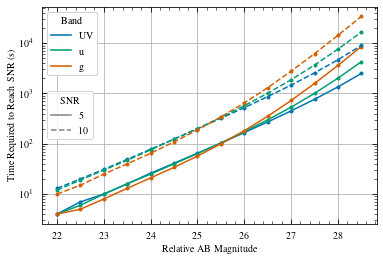

In [ ]:
#
# Plot results
# 
plot_params = {
    # Line styles for each SNR
    "ls_5": "-",
    "ls_10": "--",
    # Colours for each band
    "c_uv": sns.color_palette("colorblind")[0],
    "c_u": sns.color_palette("colorblind")[2],
    "c_g": sns.color_palette("colorblind")[3],
}
# 
fig, ax = plt.subplots()
for snr in TARGET_SNRS:
    ls = plot_params[f"ls_{snr}"]
    for band in PASSBANDS:
        color = plot_params[f"c_{band}"]
        ax.plot(ab_mags, t_lim[snr][band], ls=ls, color=color, marker=".", label=band)
handles1 = [ax.plot([],[], color="grey", ls=plot_params[f"ls_{snr}"])[0] for snr in TARGET_SNRS]
leg1 = ax.legend(handles=handles1, labels=TARGET_SNRS, loc="center left", title="SNR")
ax.add_artist(leg1)
handles2 = [ax.plot([],[], color=plot_params[f"c_{band}"])[0] for band in PASSBANDS]
leg2 = ax.legend(handles=handles2, labels=[band if band != "uv" else band.upper() for band in PASSBANDS], loc="upper left", title="Band")
ax.add_artist(leg2)
ax.semilogy()
ax.set_xlabel("Relative AB Magnitude")
ax.set_ylabel("Time Required to Reach SNR (s)")
# ax.set_title("ETC SNR Calculation Results")
# fig.savefig(const.OUTPATH + f"etc_snr_times_npix{NPIX:.2f}.pdf")
plt.show()

In [10]:
# 
# Load Table 3-6
# 
tab36 = pd.read_csv(
    const.DATAPATH + "SMS_table_3-6.txt",
    sep=" ",
    header=0,
    comment="#",
)
tab36

,mag,uv_10,u_10,g_10,uv_5,u_5,g_5
0,22.0,31,20,19,9,6,6
1,22.5,49,32,30,14,9,8
2,23.0,78,51,48,22,14,14
3,23.5,123,81,78,34,22,22
4,24.0,197,129,128,56,36,36
5,24.5,309,208,217,87,59,59
6,25.0,498,339,372,141,95,100
7,25.5,783,569,655,219,155,171
8,26.0,1267,964,1206,356,266,323
9,26.5,2039,1698,2389,561,455,609


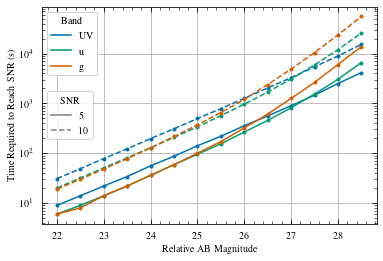

In [ ]:
# 
# Plot Table 3-6 results
#
plot_params = {
    # Line styles for each SNR
    "ls_5": "-",
    "ls_10": "--",
    # Colours for each band
    "c_uv": sns.color_palette("colorblind")[0],
    "c_u": sns.color_palette("colorblind")[2],
    "c_g": sns.color_palette("colorblind")[3],
}
# 
fig, ax = plt.subplots()
for col in tab36.columns:
    if col == "mag":
        continue
    elif col[-2:] == "10":
        ls = plot_params["ls_10"]
    elif col[-1] == "5":
        ls = plot_params["ls_5"]
    else:
        raise ValueError("Unknown SNR")
    if col[:2] == "uv":
        color = plot_params["c_uv"]
    elif col[0] == "u":
        color = plot_params["c_u"]
    else:
        color = plot_params["c_g"]
    ax.plot(tab36["mag"], tab36[col], ls=ls, color=color, marker=".", label=col)
#
handles1 = [ax.plot([],[], color="grey", ls=plot_params[f"ls_{snr}"])[0] for snr in [5, 10]]
leg1 = ax.legend(handles=handles1, labels=[5, 10], loc="center left", title="SNR")
ax.add_artist(leg1)
handles2 = [ax.plot([],[], color=plot_params[f"c_{band}"])[0] for band in ["uv", "u", "g"]]
leg2 = ax.legend(handles=handles2, labels=["UV", "u", "g"], loc="upper left", title="Band")
ax.add_artist(leg2)
ax.semilogy()
ax.set_xlabel("Relative AB Magnitude")
ax.set_ylabel("Time Required to Reach SNR (s)")
# ax.set_title("Science Maturation Study Table 3-6 Results")
# fig.savefig(const.OUTPATH + f"tab3-6_snr_times_npix{NPIX:.2f}.pdf")
plt.show()

In [ ]:
# 
# Calculate residuals
# 
residuals = pd.DataFrame({"mag": tab36["mag"]})
for snr in TARGET_SNRS:
    for band in PASSBANDS:
        residuals[f"{band}_{snr}"] = tab36[f"{band}_{snr}"].values - t_lim[snr][band].values
residuals

,mag,uv_5,u_5,g_5,uv_10,u_10,g_10
0,22.0,4,2,2,18,8,9
1,22.5,7,2,3,29,13,14
2,23.0,11,4,6,46,20,23
3,23.5,17,6,9,71,31,37
4,24.0,29,10,14,111,46,58
5,24.5,42,15,22,164,67,96
6,25.0,65,21,36,246,91,152
7,25.5,86,24,53,328,113,234
8,26.0,113,22,94,401,80,354
9,26.5,91,-28,134,296,-114,567


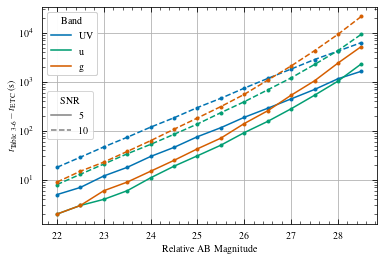

In [ ]:
# 
# Plot residuals
# 
plot_params = {
    # Line styles for each SNR
    "ls_5": "-",
    "ls_10": "--",
    # Colours for each band
    "c_uv": sns.color_palette("colorblind")[0],
    "c_u": sns.color_palette("colorblind")[2],
    "c_g": sns.color_palette("colorblind")[3],
}
fig, ax = plt.subplots()
for col in residuals.columns:
    if col == "mag":
        continue
    elif col[-2:] == "10":
        ls = plot_params["ls_10"]
    elif col[-1] == "5":
        ls = plot_params["ls_5"]
    else:
        raise ValueError("Unknown SNR")
    if col[:2] == "uv":
        color = plot_params["c_uv"]
    elif col[0] == "u":
        color = plot_params["c_u"]
    else:
        color = plot_params["c_g"]
    ax.plot(residuals["mag"], residuals[col], ls=ls, color=color, marker=".", label=col)
#
handles1 = [ax.plot([],[], color="grey", ls=plot_params[f"ls_{snr}"])[0] for snr in [5, 10]]
leg1 = ax.legend(handles=handles1, labels=[5, 10], loc="center left", title="SNR")
ax.add_artist(leg1)
handles2 = [ax.plot([],[], color=plot_params[f"c_{band}"])[0] for band in ["uv", "u", "g"]]
leg2 = ax.legend(handles=handles2, labels=["UV", "u", "g"], loc="upper left", title="Band")
ax.add_artist(leg2)
ax.semilogy()
ax.set_xlabel("Relative AB Magnitude")
ax.set_ylabel(r"$t_{\scriptstyle\text{Table~3-6}} - t_{\rm\scriptstyle ETC}$ (s)")
# ax.set_title("Residuals")
# fig.savefig(const.OUTPATH + f"snr_times_residuals_npix{NPIX:.2f}.pdf")
plt.show()

In [ ]:
#
# Calculate relative error
# 
rel_err = residuals.loc[:, residuals.columns != "mag"] / tab36.loc[:, residuals.columns != "mag"]
rel_err["mag"] = residuals["mag"]
rel_err

,g_10,g_5,u_10,u_5,uv_10,uv_5,mag
0,0.473684,0.333333,0.4,0.333333,0.580645,0.555556,22.0
1,0.5,0.375,0.40625,0.333333,0.591837,0.5,22.5
2,0.479167,0.428571,0.411765,0.285714,0.602564,0.545455,23.0
3,0.487179,0.409091,0.419753,0.272727,0.601626,0.529412,23.5
4,0.492188,0.416667,0.410853,0.305556,0.604061,0.535714,24.0
5,0.497696,0.423729,0.408654,0.322034,0.598706,0.528736,24.5
6,0.491935,0.43,0.40708,0.326316,0.600402,0.539007,25.0
7,0.477863,0.415205,0.413005,0.329032,0.590038,0.52968,25.5
8,0.461028,0.436533,0.407676,0.345865,0.587214,0.530899,26.0
9,0.453328,0.422003,0.404594,0.342857,0.574792,0.515152,26.5


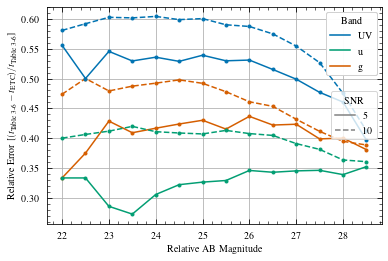

In [ ]:
# 
# Plot relative error
# 
plot_params = {
    # Line styles for each SNR
    "ls_5": "-",
    "ls_10": "--",
    # Colours for each band
    "c_uv": sns.color_palette("colorblind")[0],
    "c_u": sns.color_palette("colorblind")[2],
    "c_g": sns.color_palette("colorblind")[3],
}
fig, ax = plt.subplots()
for col in rel_err.columns:
    if col == "mag":
        continue
    elif col[-2:] == "10":
        ls = plot_params["ls_10"]
    elif col[-1] == "5":
        ls = plot_params["ls_5"]
    else:
        raise ValueError("Unknown SNR")
    if col[:2] == "uv":
        color = plot_params["c_uv"]
    elif col[0] == "u":
        color = plot_params["c_u"]
    else:
        color = plot_params["c_g"]
    ax.plot(rel_err["mag"], rel_err[col], ls=ls, color=color, marker=".", label=col)
#
handles1 = [ax.plot([],[], color="grey", ls=plot_params[f"ls_{snr}"])[0] for snr in [5, 10]]
leg1 = ax.legend(handles=handles1, labels=[5, 10], loc="center right", title="SNR")
ax.add_artist(leg1)
handles2 = [ax.plot([],[], color=plot_params[f"c_{band}"])[0] for band in ["uv", "u", "g"]]
leg2 = ax.legend(handles=handles2, labels=["UV", "u", "g"], loc="upper right", title="Band")
ax.add_artist(leg2)
# ax.semilogy()
ax.set_xlabel("Relative AB Magnitude")
ax.set_ylabel(r"Relative Error [$(t_{\scriptstyle\text{Table~3-6}} - t_{\rm\scriptstyle ETC}) / t_{\scriptstyle\text{Table~3-6}}$]")
# ax.set_title("Relative Error")
# fig.savefig(const.OUTPATH + f"snr_times_rel_errs_npix{NPIX:.2f}.pdf")
plt.show()

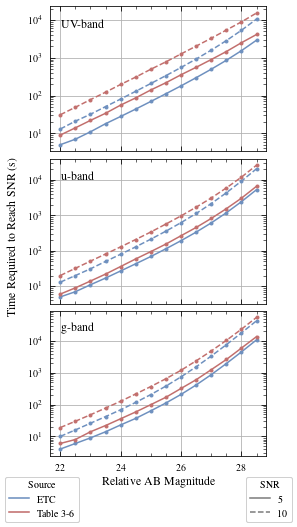

In [11]:
# 
# Plot just UV band
#
# BAND_TO_PLOT = "uv"
plot_params = {
    # Line styles for each SNR
    "ls_5": "-",
    "ls_10": "--",
    # Colours for each band
    "etc": sns.color_palette("vlag")[0],
    "tab36": sns.color_palette("vlag")[-1],
}
import matplotlib as mpl
fig, axs = plt.subplots(nrows=3, sharex=True, figsize=mpl.figure.figaspect(2))
for band, ax in zip(PASSBANDS, axs):
    for snr in TARGET_SNRS:
        ls = plot_params[f"ls_{snr}"]
        ax.plot(ab_mags, t_lim[snr][band], ls=ls, color=plot_params["etc"], marker=".")
        ax.plot(tab36["mag"], tab36[f"{band}_{snr}"], ls=ls, color=plot_params["tab36"], marker=".")
    if band == "uv":
        band = band.upper()
    ax.text(0.05, 0.86, band + "-band", c="k", ha="left", transform=ax.transAxes, fontsize=12)
    ax.semilogy()
fig.subplots_adjust(top=0.9, left=0.15, right=0.9, bottom=0.12, hspace=0.05)
handles1 = [ax.plot([],[], color="grey", ls=plot_params[f"ls_{snr}"])[0] for snr in TARGET_SNRS]
leg1 = fig.legend(handles=handles1, labels=TARGET_SNRS, loc="lower right", title="SNR")
fig.add_artist(leg1)
handles2 = [ax.plot([],[], color=plot_params[f"{source}"])[0] for source in ["etc", "tab36"]]
leg2 = fig.legend(handles=handles2, labels=["ETC", "Table~3-6"], loc="lower left", title="Source")
fig.add_artist(leg2)
# fig.text(0.5, 0.05, "Relative AB Magnitude", ha="center", fontsize=12)
ax.set_xlabel("Relative AB Magnitude", fontsize=12)
fig.text(
    0.0,
    0.5,
    "Time Required to Reach SNR (s)",
    va="center",
    rotation="vertical",
    fontsize=12,
)
# fig.savefig(const.OUTPATH + f"all_snr_times_npix{NPIX:.2f}.pdf")
fig.savefig(f"all_snr_times_npix{NPIX:.2f}_readnoise{const.READ_NOISE}.pdf")
plt.show()

In [20]:
print(INTERP_KIND)

linear
